<a href="https://colab.research.google.com/github/No0bDarren/ADALL_github/blob/main/ADALL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1 - Load data + quick profiling

In [ ]:
import pandas as pd
from pathlib import Path

data_path = Path(r"C:\Users\darre\Desktop\Python\School Project\diabetes_012_health_indicators_BRFSS2015.csv")
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print("Missing values:\n", df.isna().sum())
print("Target counts:\n", df["Diabetes_012"].value_counts().sort_index())
print("Target %:\n", (df["Diabetes_012"].value_counts(normalize=True).sort_index() * 100).round(2))

Shape: (253680, 22)
Missing values:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Target counts:
 Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64
Target %:
 Diabetes_012
0.0    84.24
1.0     1.83
2.0    13.93
Name: proportion, dtype: float64


## Step 2 - Basic EDA (distributions + class balance)

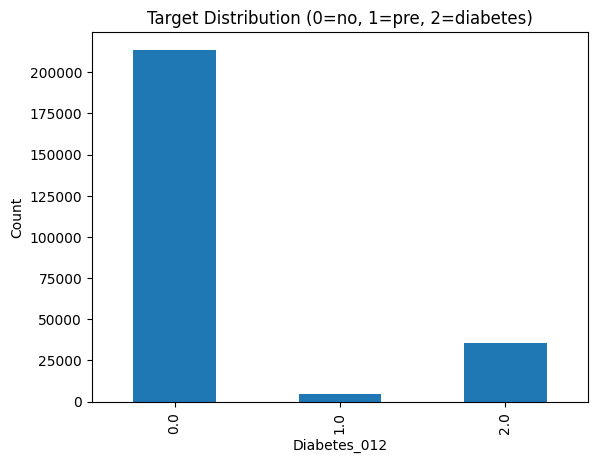

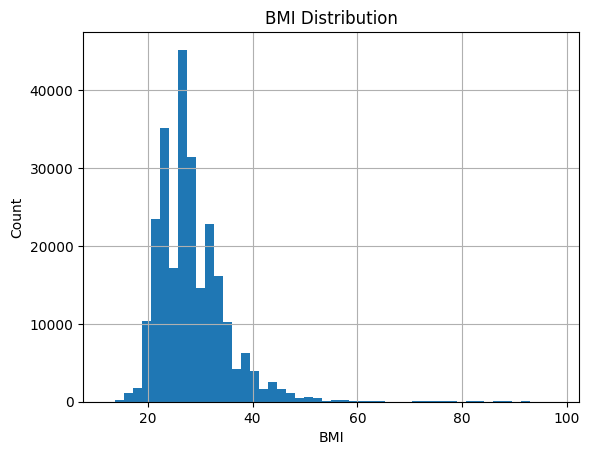

In [ ]:
import matplotlib.pyplot as plt

# Target distribution
ax = df["Diabetes_012"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target Distribution (0=no, 1=pre, 2=diabetes)")
ax.set_xlabel("Diabetes_012")
ax.set_ylabel("Count")
plt.show()

# BMI distribution
ax = df["BMI"].hist(bins=50)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()

## Step 3 - Train/test split (stratified)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

# 70/15/15 split (train/val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Feature engineering: Age group (>=40 vs <40)
# Age is ordinal bins; treat Age >= 8 as approx >= 40 years
for _df in (X_train, X_val, X_test):
    _df["AgeOver40"] = (_df["Age"] >= 8).astype(int)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (177576, 22)
Val shape: (38052, 22)
Test shape: (38052, 22)


## Step 3b - Preprocessing (log transform skewed + preserve ordinal order)


In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Skewed continuous features (right-skew)
skewed_cols = ["BMI", "MentHlth", "PhysHlth"]

# Ordinal features are kept as ordered numeric codes
ordinal_cols = ["Age", "Education", "Income", "GenHlth"]

preprocess = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), skewed_cols),
    ],
    remainder="passthrough"
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p = preprocess.transform(X_val)
X_test_p = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_p_df = pd.DataFrame(X_train_p, columns=feature_names)
X_val_p_df = pd.DataFrame(X_val_p, columns=feature_names)
X_test_p_df = pd.DataFrame(X_test_p, columns=feature_names)

print("Transformed shape:", X_train_p_df.shape)
print("Example transformed columns:", list(feature_names)[:10])


Transformed shape: (177576, 22)
Example transformed columns: ['log__BMI', 'log__MentHlth', 'log__PhysHlth', 'remainder__HighBP', 'remainder__HighChol', 'remainder__CholCheck', 'remainder__Smoker', 'remainder__Stroke', 'remainder__HeartDiseaseorAttack', 'remainder__PhysActivity']


## Step 3d - Balance training set with SMOTE (synthetic data)


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Class counts before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_p_df, y_train)

print("Class counts after SMOTE:", Counter(y_train_sm))


Class counts before SMOTE: Counter({0.0: 149592, 2.0: 24742, 1.0: 3242})
Class counts after SMOTE: Counter({0.0: 149592, 2.0: 149592, 1.0: 149592})


## Step 3c - Transformation impact (macro F1: raw vs log)


In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Raw (no log transform) baseline
scaler_raw = StandardScaler()
X_train_raw_s = scaler_raw.fit_transform(X_train)
X_val_raw_s = scaler_raw.transform(X_val)

logreg_raw = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_raw.fit(X_train_raw_s, y_train)
raw_preds = logreg_raw.predict(X_val_raw_s)
raw_f1 = f1_score(y_val, raw_preds, average="macro")

# Log-transformed baseline (uses preprocess outputs)
scaler_log = StandardScaler()
X_train_log_s = scaler_log.fit_transform(X_train_p)
X_val_log_s = scaler_log.transform(X_val_p)

logreg_log = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_log.fit(X_train_log_s, y_train)
log_preds = logreg_log.predict(X_val_log_s)
log_f1 = f1_score(y_val, log_preds, average="macro")

print(f"Macro-F1 (raw): {raw_f1:.4f}")
print(f"Macro-F1 (log): {log_f1:.4f}")
print(f"Delta (log - raw): {log_f1 - raw_f1:.4f}")

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro-F1 (raw): 0.3919
Macro-F1 (log): 0.3957
Delta (log - raw): 0.0038


## Step 4 - Baseline model pipeline (Logistic Regression)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_p)
X_val_s = scaler.transform(X_val_p)
X_test_s = scaler.transform(X_test_p)

baseline = LogisticRegression(max_iter=1000, multi_class="auto")
baseline.fit(X_train_s, y_train)

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'auto'


## Step 5 - Evaluate baseline

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = baseline.predict(X_val_s)

print("Validation report (baseline):")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))


Validation report (baseline):
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.53      0.18      0.27      5302

    accuracy                           0.85     38052
   macro avg       0.46      0.39      0.40     38052
weighted avg       0.80      0.85      0.81     38052

[[31274     0   782]
 [  606     0    88]
 [ 4335     0   967]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 6 - Second model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train_p_df, y_train)

y_val_pred_rf = rf.predict(X_val_p_df)
print("Validation report (RandomForest):")
print(classification_report(y_val, y_val_pred_rf))


Validation report (RandomForest):
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.48      0.16      0.24      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.38      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 6b - Third model (XGBoost)


In [ ]:
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost not installed. Install with: pip install xgboost") from e

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_p_df, y_train)
y_val_pred_xgb = xgb.predict(X_val_p_df)
print("Validation report (XGBoost):")
print(classification_report(y_val, y_val_pred_xgb))


Validation report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.57      0.19      0.28      5302

    accuracy                           0.85     38052
   macro avg       0.48      0.39      0.40     38052
weighted avg       0.81      0.85      0.81     38052



c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 7 - GridSearch tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train_p_df, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Validate on holdout validation set
from sklearn.metrics import classification_report
best_rf = grid.best_estimator_
y_val_pred = best_rf.predict(X_val_p_df)
print("Validation report:\n", classification_report(y_val, y_val_pred))

Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.435207327147761
Validation report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.44      0.36      0.40      5302

    accuracy                           0.83     38052
   macro avg       0.44      0.43      0.43     38052
weighted avg       0.81      0.83      0.82     38052



## Step 7b - CV tuning for Logistic Regression and XGBoost


In [ ]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression CV
logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, multi_class="auto"),
    param_grid={"C": [0.1, 1.0, 3.0], "class_weight": [None, "balanced"]},
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)
logreg_grid.fit(X_train_s, y_train)
best_logreg = logreg_grid.best_estimator_
print("Best LogReg params:", logreg_grid.best_params_)

# XGBoost CV
xgb_grid = GridSearchCV(
    XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    ),
    param_grid={
        "n_estimators": [200, 300],
        "max_depth": [3, 4],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
    },
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)
xgb_grid.fit(X_train_p_df, y_train)
best_xgb = xgb_grid.best_estimator_
print("Best XGB params:", xgb_grid.best_params_)

print("Validation report (LogReg CV best):")
print(classification_report(y_val, best_logreg.predict(X_val_s)))
print("Validation report (XGBoost CV best):")
print(classification_report(y_val, best_xgb.predict(X_val_p_df)))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LogReg params: {'C': 0.1, 'class_weight': 'balanced'}
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Validation report (LogReg CV best):
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     32056
         1.0       0.03      0.32      0.06       694
         2.0       0.36      0.60      0.45      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.53      0.43     38052
weighted avg       0.85      0.64      0.72     38052

Validation report (XGBoost CV best):
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.56      0.19      0.29      5302

    accuracy                           0.85     38052
   macro avg       0.48      0.39      0.40     38052
weighted avg       0.81      0.85      0.

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 8 - Explainability (feature importance)

In [ ]:
import pandas as pd

best_rf = grid.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print(importances.head(10))

log__BMI                0.173852
remainder__Age          0.115345
remainder__Income       0.096682
log__PhysHlth           0.078184
remainder__GenHlth      0.076372
remainder__Education    0.067983
log__MentHlth           0.065638
remainder__HighBP       0.037840
remainder__Smoker       0.034387
remainder__Fruits       0.033864
dtype: float64


## Step 9 - Error analysis (misclassifications)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Use selected final model for error analysis
y_pred_best = final_model.predict(X_eval)
cm = confusion_matrix(y_val, y_pred_best, labels=[0, 1, 2])
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Error profiles: compare feature means for misclassified vs correctly classified
errors = X_eval.copy() if hasattr(X_eval, "copy") else X_val_p_df.copy()
errors["true"] = y_val.values
errors["pred"] = y_pred_best

misclassified = errors[errors["true"] != errors["pred"]]
correct = errors[errors["true"] == errors["pred"]]

# Aggregate top differences
feature_cols = list(feature_names)
mis_means = misclassified[feature_cols].mean()
cor_means = correct[feature_cols].mean()

diff = (mis_means - cor_means).abs().sort_values(ascending=False)
print("Top feature differences (misclassified vs correct):")
print(diff.head(10))


Confusion matrix (rows=true, cols=pred):
 [[    0     0 32056]
 [    0     0   694]
 [    0     0  5302]]
Top feature differences (misclassified vs correct):
remainder__Age          1.559011
remainder__Income       0.966657
remainder__GenHlth      0.920825
log__PhysHlth           0.578866
remainder__HighBP       0.367608
remainder__Education    0.353360
remainder__HighChol     0.282773
remainder__DiffWalk     0.243192
remainder__AgeOver40    0.231217
log__MentHlth           0.169238
dtype: float64


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Step 10 - What-if analysis (sensitivity)

In [ ]:
# Adjust BMI for a single sample and see prediction changes
sample = X_test.iloc[[0]].copy()

for bmi in [25, 30, 35, 40]:
    sample["BMI"] = bmi
    sample_p = preprocess.transform(sample)
    sample_p_df = pd.DataFrame(sample_p, columns=feature_names)
    print("BMI:", bmi, "Pred:", best_rf.predict(sample_p_df)[0])

BMI: 25 Pred: 0.0
BMI: 30 Pred: 0.0
BMI: 35 Pred: 0.0
BMI: 40 Pred: 0.0


## Step 11 - Model comparison table (accuracy, macro F1, weighted F1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

models = {
    "LogReg_CV": (best_logreg, X_val_s),
    "RandomForest_CV": (best_rf, X_val_p_df),
    "XGBoost_CV": (best_xgb, X_val_p_df),
}

rows = []
for name, (model, X_eval) in models.items():
    preds = model.predict(X_eval)
    rows.append({
        "model": name,
        "accuracy_val": accuracy_score(y_val, preds),
        "f1_macro_val": f1_score(y_val, preds, average="macro"),
        "f1_weighted_val": f1_score(y_val, preds, average="weighted"),
    })

comparison = pd.DataFrame(rows).sort_values(by="f1_macro_val", ascending=False)
comparison


,model,accuracy_val,f1_macro_val,f1_weighted_val
1,RandomForest_CV,0.830337,0.434459,0.817401
0,LogReg_CV,0.643646,0.428575,0.719323
2,XGBoost_CV,0.850599,0.401419,0.813247


## Step 11a - Final model selection (validation table)


In [ ]:
# Map each model to the correct validation features
models = {
    "LogReg_CV": (best_logreg, X_val_s),
    "RandomForest_CV": (best_rf, X_val_p_df),
    "XGBoost_CV": (best_xgb, X_val_p_df),
}

# Choose final model based on the top row in comparison table
winner_name = comparison.iloc[0]["model"]
final_model, X_eval = models[winner_name]

print("FINAL MODEL:", winner_name)


FINAL MODEL: RandomForest_CV


## Step 11b - Top drivers summary (for insights write-up)


In [ ]:
# Top drivers from SHAP (mean absolute)
import shap
import numpy as np

if winner_name.startswith("LogReg"):
    print("Final model is Logistic Regression. Use coefficients or permutation importance; TreeExplainer not applicable.")
else:
    # Limit SHAP to a small sample for speed
    X_shap = X_eval.iloc[:300] if hasattr(X_eval, "iloc") else X_eval[:300]

    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer(X_shap)

    class_idx = 1  # 0=no, 1=prediabetes, 2=diabetes
    sv = shap_values[..., class_idx]
    shap_abs = np.abs(sv.values).mean(axis=0)
    shap_top = pd.Series(shap_abs, index=feature_names).sort_values(ascending=False).head(5)
    print("Top SHAP features:\n", shap_top)


Top SHAP features:
 log__BMI             0.051652
remainder__Age       0.033558
remainder__Income    0.031390
log__PhysHlth        0.024638
log__MentHlth        0.023706
dtype: float64


## Step 13 - Permutation Feature Importance (pFI)

In [ ]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    final_model, X_eval, y_val,
    n_repeats=5, random_state=42, scoring="f1_macro"
)

importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)
print(importances.head(10))


log__BMI                           0.034379
remainder__GenHlth                 0.033564
remainder__HighBP                  0.026607
remainder__HighChol                0.014562
remainder__Age                     0.010136
remainder__Income                  0.004284
remainder__HeartDiseaseorAttack    0.003451
remainder__DiffWalk                0.003247
remainder__HvyAlcoholConsump       0.002476
remainder__AgeOver40               0.002456
dtype: float64


## Step 14 - SHAP (global + local explainability)

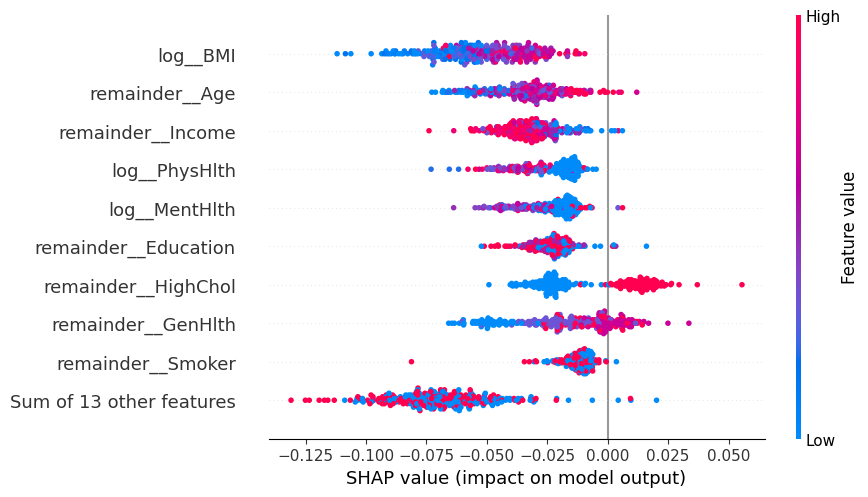

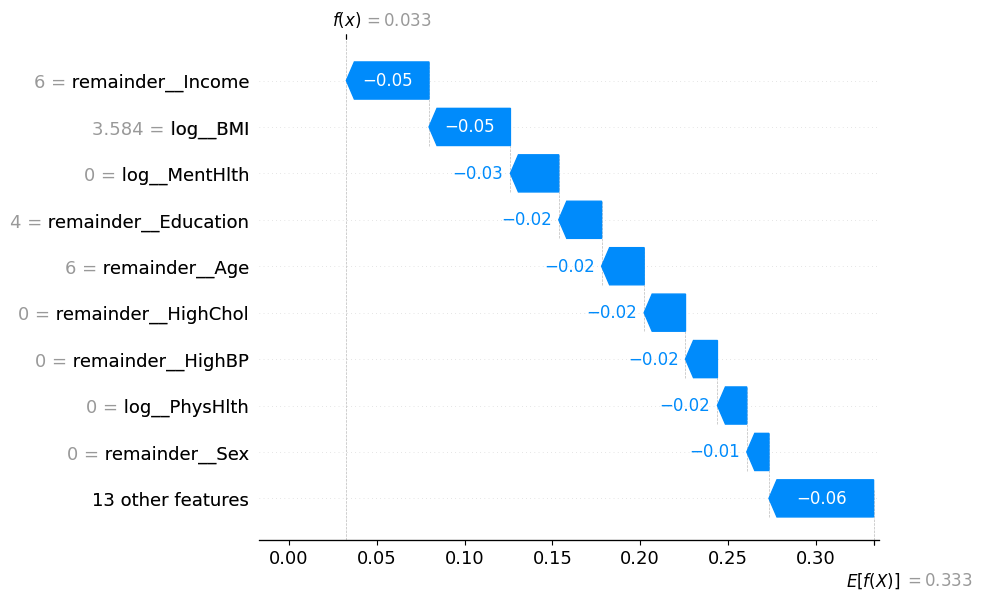

In [ ]:
try:
    import shap
except ImportError as e:
    raise ImportError("shap not installed. Install with: pip install shap") from e

if winner_name.startswith("LogReg"):
    print("Final model is Logistic Regression. Skip SHAP TreeExplainer.")
else:
    # Limit SHAP to a small sample for speed
    X_shap = X_eval.iloc[:300] if hasattr(X_eval, "iloc") else X_eval[:300]

    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer(X_shap)

    class_idx = 1
    sv = shap_values[..., class_idx]

    # Global summary plot
    shap.plots.beeswarm(sv)

    # Local explanation for one sample
    i = 0
    shap.plots.waterfall(sv[i])


## Step 16 - Class-weighted models (optimize class-1 recall)

In [ ]:
from sklearn.metrics import classification_report

# Class-weighted Logistic Regression
logreg_cw = LogisticRegression(max_iter=1000, multi_class="auto", class_weight="balanced")
logreg_cw.fit(X_train_s, y_train)
logreg_cw_preds = logreg_cw.predict(X_val_s)
print("Validation report (LogReg class_weight=balanced)")
print(classification_report(y_val, logreg_cw_preds))

# Class-weighted Random Forest
rf_cw = RandomForestClassifier(
    n_estimators=400, random_state=42, class_weight="balanced"
)
rf_cw.fit(X_train_p_df, y_train)
rf_cw_preds = rf_cw.predict(X_val_p_df)
print("Validation report (RandomForest class_weight=balanced)")
print(classification_report(y_val, rf_cw_preds))


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation report (LogReg class_weight=balanced)
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     32056
         1.0       0.03      0.32      0.06       694
         2.0       0.36      0.60      0.45      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.53      0.43     38052
weighted avg       0.85      0.64      0.72     38052

Validation report (RandomForest class_weight=balanced)
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.48      0.16      0.24      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.38      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 17 - SMOTE + model training (focus on class-1 recall)

In [ ]:
from sklearn.metrics import classification_report

# Train RF on SMOTE data from Step 3d
rf_sm = RandomForestClassifier(n_estimators=400, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
rf_sm_preds = rf_sm.predict(X_val_p_df)
print("Validation report (RandomForest + SMOTE)")
print(classification_report(y_val, rf_sm_preds))


Validation report (RandomForest + SMOTE)
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     32056
         1.0       0.01      0.00      0.00       694
         2.0       0.44      0.31      0.36      5302

    accuracy                           0.83     38052
   macro avg       0.44      0.42      0.42     38052
weighted avg       0.80      0.83      0.81     38052



## Step 18 - Precision-Recall curve + threshold tuning for class 1

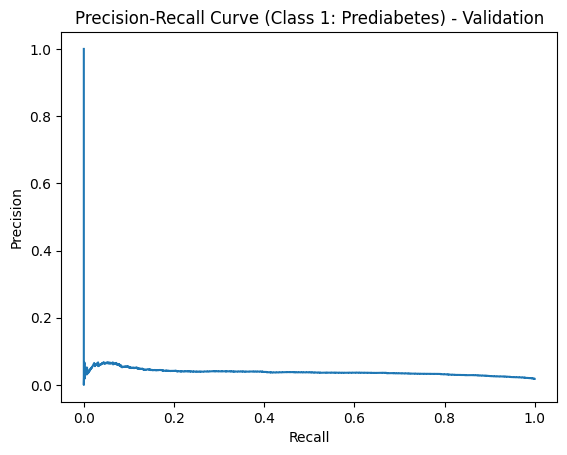

Selected threshold: 0.0221037
Validation report (XGBoost threshold-tuned for class 1)
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.81     32056
         1.0       0.03      0.70      0.07       694
         2.0       0.67      0.01      0.01      5302

    accuracy                           0.61     38052
   macro avg       0.55      0.47      0.30     38052
weighted avg       0.89      0.61      0.68     38052



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Tune threshold on validation only
probs = best_xgb.predict_proba(X_val_p_df)
class1_probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve((y_val == 1).astype(int), class1_probs)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Class 1: Prediabetes) - Validation")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Choose threshold to maximize recall while keeping precision reasonable
valid_idx = np.where(recall >= 0.70)[0]
if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(precision[valid_idx])]
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    print("Selected threshold:", best_thresh)
else:
    best_thresh = 0.5
    print("Fallback threshold:", best_thresh)

# Apply tuned threshold on validation
preds = best_xgb.predict(X_val_p_df)
preds_tuned_val = preds.copy()
preds_tuned_val[class1_probs >= best_thresh] = 1

print("Validation report (XGBoost threshold-tuned for class 1)")
print(classification_report(y_val, preds_tuned_val))


## Step 19 - Consolidated model tracking (accuracy, macro-F1, class-1 recall, class-2 recall)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

rows = []

def add_row(name, model, X_eval, y_eval, tuned_preds=None):
    preds = tuned_preds if tuned_preds is not None else model.predict(X_eval)
    rows.append({
        "model": name,
        "accuracy_val": accuracy_score(y_eval, preds),
        "f1_macro_val": f1_score(y_eval, preds, average="macro"),
        "recall_c1_val": recall_score(y_eval, preds, labels=[1], average=None)[0],
        "recall_c2_val": recall_score(y_eval, preds, labels=[2], average=None)[0],
    })

# CV-tuned core models
add_row("LogReg_CV", best_logreg, X_val_s, y_val)
add_row("RandomForest_CV", best_rf, X_val_p_df, y_val)
add_row("XGBoost_CV", best_xgb, X_val_p_df, y_val)

# Optional imbalance-focused variants on validation
add_row("LogReg_class_weight", logreg_cw, X_val_s, y_val)
add_row("RF_class_weight", rf_cw, X_val_p_df, y_val)
add_row("RF_SMOTE", rf_sm, X_val_p_df, y_val)
add_row("XGB_threshold_tuned", best_xgb, X_val_p_df, y_val, tuned_preds=preds_tuned_val)

tracking = pd.DataFrame(rows).sort_values(by=["recall_c1_val", "f1_macro_val"], ascending=False)
tracking


,model,accuracy_val,f1_macro_val,recall_c1_val,recall_c2_val
6,XGB_threshold_tuned,0.606801,0.295365,0.701729,0.007356
0,LogReg_CV,0.643646,0.428575,0.321326,0.599208
3,LogReg_class_weight,0.643619,0.428536,0.321326,0.599019
5,RF_SMOTE,0.832440,0.423410,0.001441,0.307054
1,RandomForest_CV,0.830337,0.434459,0.000000,0.364957
2,XGBoost_CV,0.850599,0.401419,0.000000,0.192003
4,RF_class_weight,0.839824,0.383513,0.000000,0.158808


## Step 20 - Final model selection (validation-first)

Selection rule: maximize class-1 recall on validation, then break ties with macro-F1.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate final model once on test set
# Choose correct test features based on winner_name
if winner_name.startswith("LogReg"):
    X_test_final = X_test_s
else:
    X_test_final = X_test_p_df

y_final_pred = final_model.predict(X_test_final)
print("Final test classification report (one-time holdout):")
print(classification_report(y_test, y_final_pred, digits=3))
print("Final test confusion matrix:")
print(confusion_matrix(y_test, y_final_pred, labels=[0, 1, 2]))


Final test classification report (one-time holdout):
              precision    recall  f1-score   support

         0.0      0.886     0.925     0.905     32055
         1.0      0.000     0.000     0.000       695
         2.0      0.448     0.380     0.411      5302

    accuracy                          0.832     38052
   macro avg      0.445     0.435     0.439     38052
weighted avg      0.809     0.832     0.820     38052

Final test confusion matrix:
[[29660    76  2319]
 [  528     0   167]
 [ 3271    16  2015]]


## Step 21 - Retrain final model on train+val (optional, production-style)

Refit the chosen model on train+val, then evaluate once on test.


In [ ]:
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix

# Combine train + val
X_trainval_p_df = pd.concat([X_train_p_df, X_val_p_df], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
X_trainval_s = np.vstack([X_train_s, X_val_s])

# Choose the right feature space based on winner_name
if winner_name.startswith("LogReg"):
    X_trainval = X_trainval_s
    X_test_final = X_test_s
else:
    X_trainval = X_trainval_p_df
    X_test_final = X_test_p_df

final_model_retrained = clone(final_model)
final_model_retrained.fit(X_trainval, y_trainval)

y_final_retrained = final_model_retrained.predict(X_test_final)
print("Retrained final model test report:")
print(classification_report(y_test, y_final_retrained, digits=3))
print("Retrained final model confusion matrix:")
print(confusion_matrix(y_test, y_final_retrained, labels=[0, 1, 2]))


Retrained final model test report:
              precision    recall  f1-score   support

         0.0      0.887     0.921     0.904     32055
         1.0      0.009     0.001     0.002       695
         2.0      0.437     0.384     0.409      5302

    accuracy                          0.829     38052
   macro avg      0.445     0.435     0.438     38052
weighted avg      0.808     0.829     0.818     38052

Retrained final model confusion matrix:
[[29525    87  2443]
 [  519     1   175]
 [ 3248    19  2035]]
